<a href="https://colab.research.google.com/github/pshemach/Machine-Failures-Kaggle/blob/main/Binary_Classification_of_Machine_Failures.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'playground-series-s3e17:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-competitions-data%2Fkaggle-v2%2F53376%2F5988351%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240229%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240229T071920Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D2813ac71e68900d88aa1fd791482ccff419daa2a5998ef843b5cf62cdc87140e19caa24051f235983a3dfc7b399862b8435fbd324e5468e3866fa77d9571b3218e7f8c565e328ad307740e72020d692bcb9c819a5cf7f3db887b4f2de5811ac9cdc7beed599215cbcfce2182510589e22023a7172b5c501a21ddb6071bc494ad044a049fb0152a7d5daa516febf64da1511a89494063905c90cf21f4c856afa32370d58aadae296961751e46da9c78a0b16a030bad46f440be7c4dd62c4685dfd1dd3838c06fd643634e25a4d64de7cbdd6fb074d5b8ff0eb8b5c4a0f73acb4cdf110445ba51ea74feb3232fe0bc227c4839d991e6afed9549ccc469b5b82acb'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 3655169 bytes downloaded
Downloaded and uncompressed: playground-series-s3e17
Data source import complete.


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [3]:
train = pd.read_csv('/kaggle/input/playground-series-s3e17/train.csv')
train.head()

,id,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,0,L50096,L,300.6,309.6,1596,36.1,140,0,0,0,0,0,0
1,1,M20343,M,302.6,312.1,1759,29.1,200,0,0,0,0,0,0
2,2,L49454,L,299.3,308.5,1805,26.5,25,0,0,0,0,0,0
3,3,L53355,L,301.0,310.9,1524,44.3,197,0,0,0,0,0,0
4,4,M24050,M,298.0,309.0,1641,35.4,34,0,0,0,0,0,0


In [4]:
test = pd.read_csv('/kaggle/input/playground-series-s3e17/test.csv')
test.head()

,id,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],TWF,HDF,PWF,OSF,RNF
0,136429,L50896,L,302.3,311.5,1499,38.0,60,0,0,0,0,0
1,136430,L53866,L,301.7,311.0,1713,28.8,17,0,0,0,0,0
2,136431,L50498,L,301.3,310.4,1525,37.7,96,0,0,0,0,0
3,136432,M21232,M,300.1,309.6,1479,47.6,5,0,0,0,0,0
4,136433,M19751,M,303.4,312.3,1515,41.3,114,0,0,0,0,0


In [5]:
train.shape , test.shape

((136429, 14), (90954, 13))

In [6]:
train.tail()

,id,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
136424,136424,M22284,M,300.1,311.4,1530,37.5,210,0,0,0,0,0,0
136425,136425,H38017,H,297.5,308.5,1447,49.1,2,0,0,0,0,0,0
136426,136426,L54690,L,300.5,311.8,1524,38.5,214,0,0,0,0,0,0
136427,136427,L53876,L,301.7,310.9,1447,46.3,42,0,0,0,0,0,0
136428,136428,L47937,L,296.9,308.1,1557,39.3,229,0,0,0,0,0,0


In [7]:
train.isnull().sum()

id                         0
Product ID                 0
Type                       0
Air temperature [K]        0
Process temperature [K]    0
Rotational speed [rpm]     0
Torque [Nm]                0
Tool wear [min]            0
Machine failure            0
TWF                        0
HDF                        0
PWF                        0
OSF                        0
RNF                        0
dtype: int64

In [8]:
test.isnull().sum()

id                         0
Product ID                 0
Type                       0
Air temperature [K]        0
Process temperature [K]    0
Rotational speed [rpm]     0
Torque [Nm]                0
Tool wear [min]            0
TWF                        0
HDF                        0
PWF                        0
OSF                        0
RNF                        0
dtype: int64

In [9]:
train.describe()

,id,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
count,136429.000000,136429.000000,136429.000000,136429.000000,136429.000000,136429.000000,136429.000000,136429.000000,136429.000000,136429.000000,136429.000000,136429.000000
mean,68214.000000,299.862776,309.941070,1520.331110,40.348643,104.408901,0.015744,0.001554,0.005160,0.002397,0.003958,0.002258
std,39383.804275,1.862247,1.385173,138.736632,8.502229,63.965040,0.124486,0.039389,0.071649,0.048899,0.062789,0.047461
min,0.000000,295.300000,305.800000,1181.000000,3.800000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,34107.000000,298.300000,308.700000,1432.000000,34.600000,48.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,68214.000000,300.000000,310.000000,1493.000000,40.400000,106.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,102321.000000,301.200000,310.900000,1580.000000,46.100000,159.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,136428.000000,304.400000,313.800000,2886.000000,76.600000,253.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [10]:
test.describe()

,id,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],TWF,HDF,PWF,OSF,RNF
count,90954.000000,90954.000000,90954.000000,90954.000000,90954.000000,90954.000000,90954.000000,90954.000000,90954.000000,90954.00000,90954.000000
mean,181905.500000,299.859493,309.939375,1520.528179,40.335191,104.293962,0.001473,0.005343,0.002353,0.00387,0.002309
std,26256.302529,1.857562,1.385296,139.970419,8.504683,63.871092,0.038355,0.072903,0.048449,0.06209,0.047995
min,136429.000000,295.300000,305.700000,1168.000000,3.800000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
25%,159167.250000,298.300000,308.700000,1432.000000,34.600000,48.000000,0.000000,0.000000,0.000000,0.00000,0.000000
50%,181905.500000,300.000000,310.000000,1493.000000,40.500000,106.000000,0.000000,0.000000,0.000000,0.00000,0.000000
75%,204643.750000,301.200000,310.900000,1579.000000,46.200000,158.000000,0.000000,0.000000,0.000000,0.00000,0.000000
max,227382.000000,304.400000,313.800000,2886.000000,76.600000,253.000000,1.000000,1.000000,1.000000,1.00000,1.000000


In [11]:
train.columns

Index(['id', 'Product ID', 'Type', 'Air temperature [K]',
       'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]',
       'Tool wear [min]', 'Machine failure', 'TWF', 'HDF', 'PWF', 'OSF',
       'RNF'],
      dtype='object')

In [12]:
train[['Machine failure']].value_counts()

Machine failure
0                  134281
1                    2148
dtype: int64

<Axes: xlabel='Machine failure', ylabel='count'>

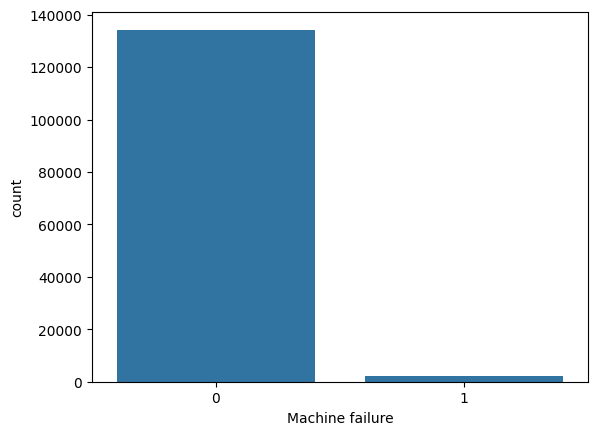

In [13]:
sns.countplot(train, x='Machine failure')

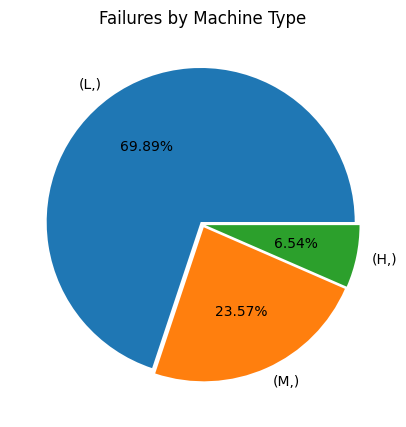

In [14]:
train[['Type']].value_counts().plot(kind='pie',explode=[.02,.02,.02],autopct='%1.2f%%',
                                  figsize=(8,5))

plt.title('Failures by Machine Type')
plt.show()

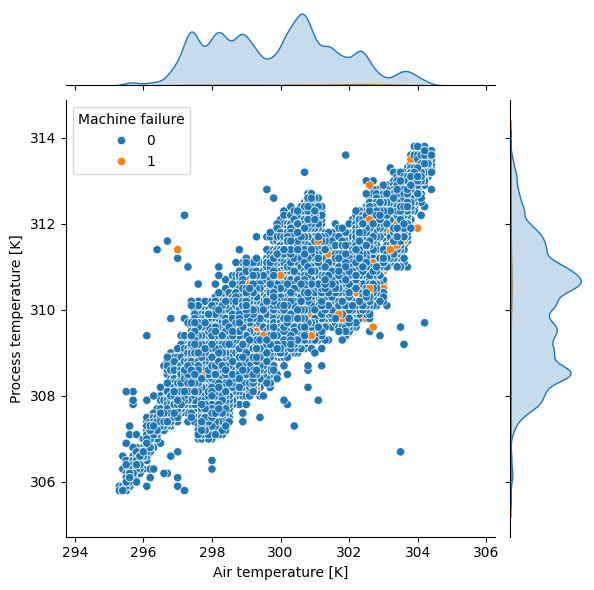

In [15]:
sns.jointplot(x='Air temperature [K]',y='Process temperature [K]',data=train,kind='scatter',hue='Machine failure')

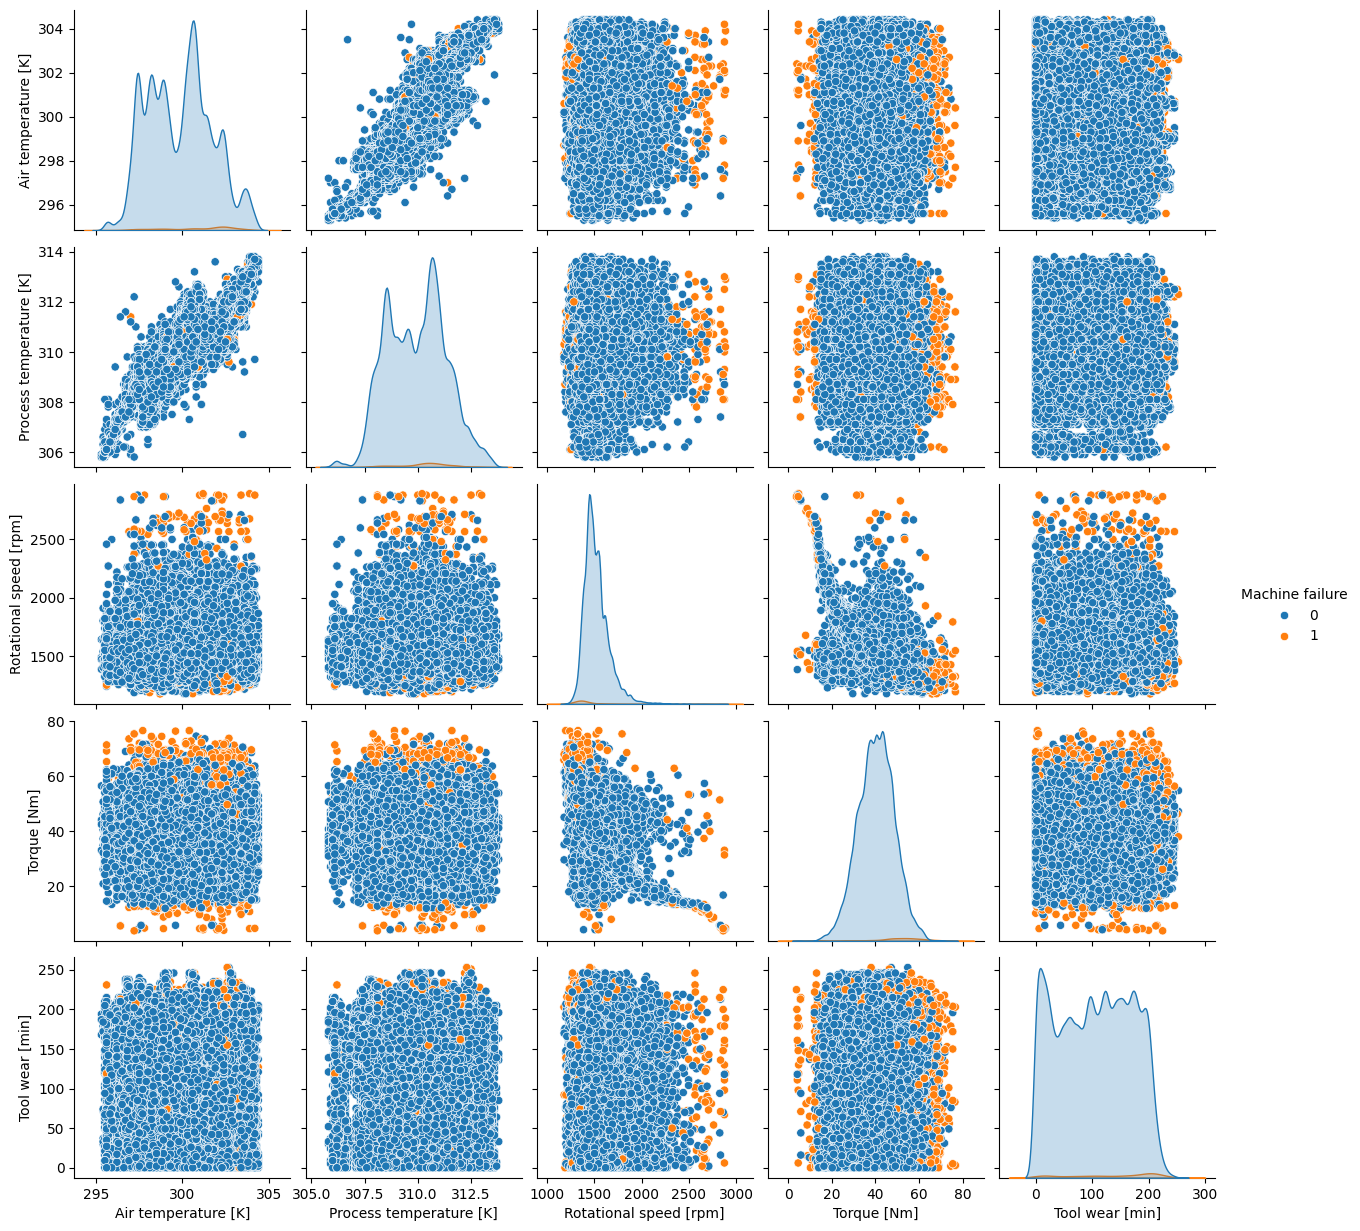

In [16]:
sns.pairplot(data=train[['Air temperature [K]','Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]',
       'Tool wear [min]','Machine failure']], hue='Machine failure')

In [17]:
X = train.drop(['id', 'Product ID','Machine failure'],axis=1)
X = pd.get_dummies(X, columns=['Type'])

y = train['Machine failure']

X.head()

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],TWF,HDF,PWF,OSF,RNF,Type_H,Type_L,Type_M
0,300.6,309.6,1596,36.1,140,0,0,0,0,0,0,1,0
1,302.6,312.1,1759,29.1,200,0,0,0,0,0,0,0,1
2,299.3,308.5,1805,26.5,25,0,0,0,0,0,0,1,0
3,301.0,310.9,1524,44.3,197,0,0,0,0,0,0,1,0
4,298.0,309.0,1641,35.4,34,0,0,0,0,0,0,0,1


In [18]:
X.columns

Index(['Air temperature [K]', 'Process temperature [K]',
       'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]', 'TWF',
       'HDF', 'PWF', 'OSF', 'RNF', 'Type_H', 'Type_L', 'Type_M'],
      dtype='object')

In [19]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

scaler.fit(X.drop(['TWF','HDF', 'PWF', 'OSF', 'RNF', 'Type_H', 'Type_L', 'Type_M'], axis=1))

scaled_feature = scaler.transform(X.drop(['TWF','HDF', 'PWF', 'OSF', 'RNF', 'Type_H', 'Type_L', 'Type_M'], axis=1))

scaled_feature = pd.DataFrame(scaled_feature, columns=['Air temperature [K]', 'Process temperature [K]',
                                                       'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]'])

X = scaled_feature.join(X[['TWF','HDF', 'PWF', 'OSF', 'RNF', 'Type_H', 'Type_L', 'Type_M']])

X.head()

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],TWF,HDF,PWF,OSF,RNF,Type_H,Type_L,Type_M
0,0.395880,-0.246230,0.545416,-0.499711,0.556417,0,0,0,0,0,0,1,0
1,1.469856,1.558605,1.720308,-1.323028,1.494433,0,0,0,0,0,0,0,1
2,-0.302204,-1.040358,2.051873,-1.628831,-1.241447,0,0,0,0,0,0,1,0
3,0.610675,0.692284,0.026445,0.464745,1.447532,0,0,0,0,0,0,1,0
4,-1.000288,-0.679391,0.869773,-0.582043,-1.100744,0,0,0,0,0,0,0,1


In [20]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [21]:
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier

RF_model = RandomForestClassifier(n_estimators=200)

RF_model.fit(X_train,y_train)

RF_pred = RF_model.predict(X_test)

print(classification_report(RF_pred,y_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     26945
           1       0.77      0.99      0.86       341

    accuracy                           1.00     27286
   macro avg       0.88      0.99      0.93     27286
weighted avg       1.00      1.00      1.00     27286



In [22]:
import tensorflow as tf

In [23]:
from sklearn.ensemble import AdaBoostClassifier

AB_model = AdaBoostClassifier(n_estimators=100)

AB_model.fit(X_train,y_train)

AB_pred = AB_model.predict(X_test)

print(classification_report(AB_pred,y_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     26942
           1       0.77      0.98      0.86       344

    accuracy                           1.00     27286
   macro avg       0.89      0.99      0.93     27286
weighted avg       1.00      1.00      1.00     27286



In [24]:
y_test.value_counts()

0    26848
1      438
Name: Machine failure, dtype: int64

In [25]:
DL_model = tf.keras.Sequential([

    tf.keras.layers.Dense(50,'relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(50,'relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(50,'relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(1,'sigmoid'),

      ])

DL_model.compile(loss = tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

DL_model.fit(X_train,y_train , epochs=10 , validation_data=(X_test,y_test))

Epoch 1/10
3411/3411 [==============================] - 11s 3ms/step - loss: 0.0386 - accuracy: 0.9932 - val_loss: 0.0231 - val_accuracy: 0.9962
Epoch 2/10
3411/3411 [==============================] - 9s 3ms/step - loss: 0.0235 - accuracy: 0.9961 - val_loss: 0.0233 - val_accuracy: 0.9961
Epoch 3/10
3411/3411 [==============================] - 8s 2ms/step - loss: 0.0233 - accuracy: 0.9960 - val_loss: 0.0222 - val_accuracy: 0.9962
Epoch 4/10
3411/3411 [==============================] - 9s 3ms/step - loss: 0.0226 - accuracy: 0.9961 - val_loss: 0.0223 - val_accuracy: 0.9962
Epoch 5/10
3411/3411 [==============================] - 9s 3ms/step - loss: 0.0223 - accuracy: 0.9961 - val_loss: 0.0235 - val_accuracy: 0.9962
Epoch 6/10
3411/3411 [==============================] - 8s 2ms/step - loss: 0.0220 - accuracy: 0.9962 - val_loss: 0.0228 - val_accuracy: 0.9962
Epoch 7/10
3411/3411 [==============================] - 9s 3ms/step - loss: 0.0219 - accuracy: 0.9961 - val_loss: 0.0225 - val_accuracy

In [26]:
DL_pred = DL_model.predict(X_test)

DL_pred = (DL_pred > 0.5).astype(int)

print(classification_report(DL_pred,y_test))

853/853 [==============================] - 1s 1ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     26947
           1       0.77      0.99      0.86       339

    accuracy                           1.00     27286
   macro avg       0.88      0.99      0.93     27286
weighted avg       1.00      1.00      1.00     27286



In [27]:
X_sub = test.drop(['id', 'Product ID'],axis=1)
X_sub = pd.get_dummies(X_sub, columns=['Type'])
X_sub.head()

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],TWF,HDF,PWF,OSF,RNF,Type_H,Type_L,Type_M
0,302.3,311.5,1499,38.0,60,0,0,0,0,0,0,1,0
1,301.7,311.0,1713,28.8,17,0,0,0,0,0,0,1,0
2,301.3,310.4,1525,37.7,96,0,0,0,0,0,0,1,0
3,300.1,309.6,1479,47.6,5,0,0,0,0,0,0,0,1
4,303.4,312.3,1515,41.3,114,0,0,0,0,0,0,0,1


In [28]:
sub_scaler = StandardScaler()

sub_scaler.fit(X_sub.drop(['TWF','HDF', 'PWF', 'OSF', 'RNF', 'Type_H', 'Type_L', 'Type_M'], axis=1))

sub_scaled_feature = sub_scaler.transform(X_sub.drop(['TWF','HDF', 'PWF', 'OSF', 'RNF', 'Type_H', 'Type_L', 'Type_M'], axis=1))

sub_scaled_feature = pd.DataFrame(sub_scaled_feature, columns=['Air temperature [K]', 'Process temperature [K]',
                                                       'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]'])

X_sub = sub_scaled_feature.join(X_sub[['TWF','HDF', 'PWF', 'OSF', 'RNF', 'Type_H', 'Type_L', 'Type_M']])

X_sub.head()

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],TWF,HDF,PWF,OSF,RNF,Type_H,Type_L,Type_M
0,1.313830,1.126570,-0.153806,-0.274579,-0.693494,0,0,0,0,0,0,1,0
1,0.990824,0.765635,1.375097,-1.356341,-1.366729,0,0,0,0,0,0,1,0
2,0.775487,0.332512,0.031949,-0.309854,-0.129855,0,0,0,0,0,0,1,0
3,0.129475,-0.244985,-0.296694,0.854217,-1.554608,0,0,0,0,0,0,0,1
4,1.906008,1.704068,-0.039496,0.113445,0.151964,0,0,0,0,0,0,0,1


In [29]:
DL_pred_sub = DL_model.predict(X_sub)

2843/2843 [==============================] - 4s 1ms/step


In [30]:
submission = test[['id']]
submission['Machine failure'] = DL_pred_sub

<ipython-input-30-311ae2946e71>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  submission['Machine failure'] = DL_pred_sub


In [31]:
submission.to_csv('DL_sub.csv',index=False)